# Time Series Modelling and Forecasting

- In typical ML, data is cross-sectional; values of one data point do not influence another data point.
- In time series data, the data points are dependent of each other and the order of data matters.
- These methods can be used on ordered data; does not need to strictly be based on time.
- Time series can have *granularity* on yearly, monthly, weekly, daily, etc. periods.
- *Frequency* refers to how often data is collected (every 3 hours, etc.).
- With clever feature engineering, traditional models can also work.

## References

1. Practical Time Series Analysis
1. Python Data Science Handbook, Chapter 3
1. Python for Data Analysis, Chapter 11
1. [Wikipedia - Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)

# Basics

Time series can be distinguished by using previous measurements to determine current or future measurements. This can be represented as a linear equation:

$$
    p_t = \alpha_{t-1}p_{t-1} + \alpha_{t-2}p_{t-2} + \ldots + \alpha_{t-k}p_{t-k} + b
$$

## Testing Time Series

Time series models can never truly be tested because future data is unknown. However, highly similar or a series of highly similar data from the past can be tested that is then extrapolated to the forecasting model.

## Curse of Lookahead Data

The term *lookahead* is used in time series analysis to denote any knowledge of the future. You shouldn’t have such knowledge when designing, training, or evaluating a model. A lookahead is a way, through data, to find out something about the future
earlier than you ought to know it.

A lookahead is any way that information about what will happen in the future might propagate back in time in your modeling and affect how your model behaves earlier in time. For example, when choosing hyperparameters for a model, you might test the model at various times in your data set, then choose the best model and start at the beginning of your data to test this model. This is problematic because you chose the model for one time knowing things that would happen at a subsequent time—a lookahead.

Unfortunately, there is no automated code or statistical test for a lookahead, so it is something you must be vigilant and thoughtful about.

*Example: using a rolling average that includes $t+1\ldots$ in its calculation*.

# Data

Monthly mean atmospheric CO2 levels from the Mauna Loa Observatory.

Source: [https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html)

In [1]:
import datetime
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt

from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

In [2]:
co2 = pd.read_csv('./data/co2.csv', usecols=['year','month', 'average'], index_col=False)

In [3]:
co2.head()

,year,month,average
0,1958,3,315.70
1,1958,4,317.45
2,1958,5,317.51
3,1958,6,317.24
4,1958,7,315.86


In [4]:
co2['date'] = pd.to_datetime(co2[['year','month']].assign(DAY=1))

In [5]:
co2 = co2.set_index('date', drop=True).drop(['year','month'], axis=1)
co2.head()

,average
date,
1958-03-01,315.70
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.24
1958-07-01,315.86


In [6]:
# TODO: Add train-test-split on data to run the predictions

# STL Decomposition

*Seasonal-Trend-LOESS*

Trend component is removed using a LOESS regression model, which is a non-linear regression method that builds on the ideas developed in linear regression.

The seasonal component is removed using a regression on periodic components.

The remainder is known as the residual and should behave like white noise. In time series analysis, the residuals are sometimes called *innovations*.

## Additive Model

Seasonal variation is constant. The *additive model* sums seasonality, trend, and residuals.

$$
    TS(t) = S(t) + T(t) + R(t)
$$

## Multiplicative 

Seasonal variation is proportional to the trend (e.g. as the trend goes up, the season variation is greater). The *multiplicative model* is the product of seasonality, trend, and residuals. This model can be turned into an additive model using log transformation.

$$
    TS(t) = S(t) \cdot T(t) \cdot R(t)
$$

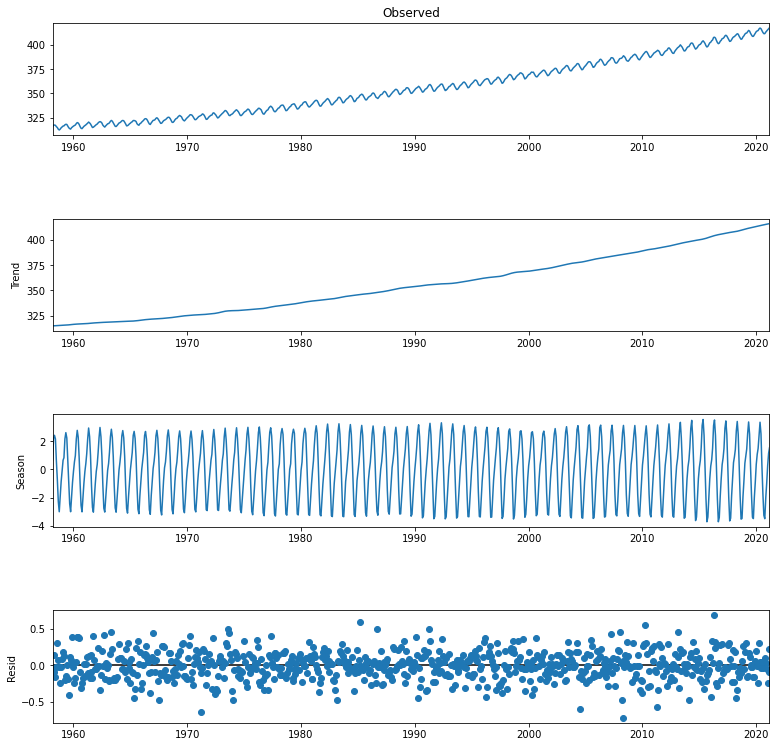

In [7]:
stl = STL(co2)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12, 12)
plt.show()

# ACF

ACF is the *auto-correlation function*.

Autocorrelation, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of the delay. Informally, it is the similarity between observations as a function of the time lag between them.

Autocorrelation gives you an idea of how data points at different points in time are linearly related to one another as a function of their time difference.

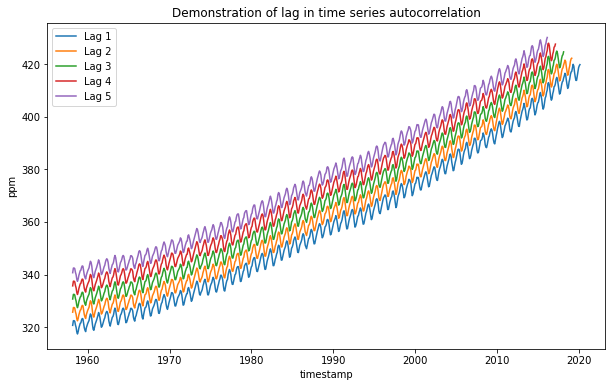

In [8]:
plt.figure(figsize=(10,6))
for i in range(1, 6):
    plt.plot(co2[:-i*12] + (i * 5))
plt.xlabel('timestamp')
plt.ylabel('ppm')
plt.legend([f'Lag {i}' for i in range(1, 6)])
plt.title('Demonstration of lag in time series autocorrelation')
plt.show()

In [9]:
stattools.acf(co2, nlags=36, fft=False)

array([1.        , 0.99494551, 0.988831  , 0.98238813, 0.9763931 ,
       0.97120864, 0.96699922, 0.96353783, 0.96078294, 0.95868349,
       0.95680038, 0.95446127, 0.95098339, 0.94603181, 0.93992172,
       0.93347284, 0.92750592, 0.92236046, 0.91814404, 0.91470873,
       0.91197262, 0.90991706, 0.90802275, 0.90566487, 0.90221031,
       0.89730578, 0.89126012, 0.88493942, 0.87908704, 0.87402245,
       0.86986396, 0.86648018, 0.86378741, 0.86173767, 0.85987222,
       0.85755667, 0.85414389])

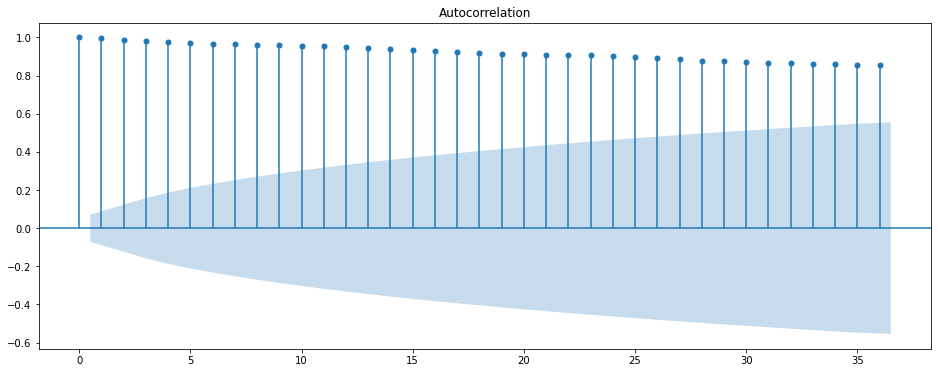

In [10]:
fig, ax = plt.subplots(figsize=(16,6))
tsaplots.plot_acf(co2, lags=36, ax=ax)
plt.show()

# PACF

PACF is *partial auto-correlation function*

The partial autocorrelation of a time series for a given lag is the partial correlation of the time series with itself at that lag given all the information between the two points in time.

The PACF shows which data points are informative and which are harmonics of shorter time periods.

The critical region is the same for ACF, bounded at $\pm1.96\sqrt{n}$.

In [11]:
stattools.pacf(co2, nlags=36)

array([ 1.        ,  0.99626158, -0.14561653, -0.02831332,  0.06750396,
        0.09111247,  0.09905546,  0.06656412,  0.07846116,  0.08725907,
        0.03590683, -0.03933832, -0.11006011, -0.1393222 , -0.10164372,
       -0.02257881,  0.04119571,  0.04412767,  0.04411336,  0.03069337,
        0.04244811,  0.07015344,  0.02686674, -0.01541777, -0.06296989,
       -0.09798422, -0.07577112, -0.01000128,  0.02584265,  0.02116657,
        0.02475426,  0.01665851,  0.02959518,  0.05532905,  0.02898098,
       -0.00454522, -0.0461976 ])

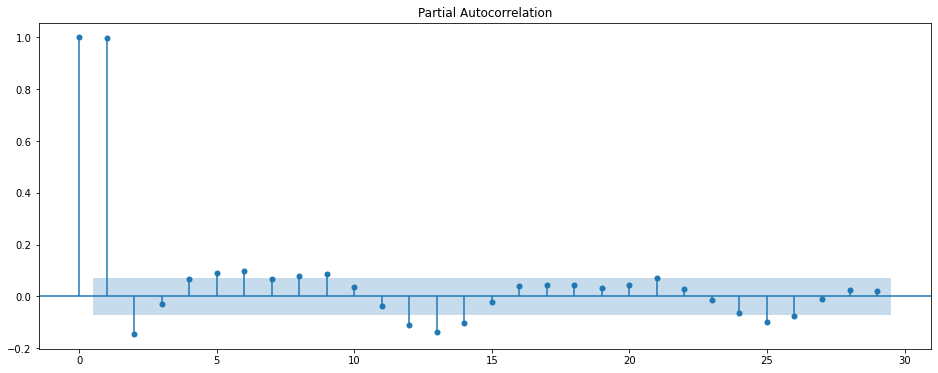

In [12]:
fig, ax = plt.subplots(figsize=(16,6))
tsaplots.plot_pacf(co2, ax=ax)
plt.show()

# Linear Regression

Ordinary least squares linear regression can be applied to time series data provided the following
conditions hold:

Assumptions with respect to the behavior of the time series

- The time series has a linear response to its predictors.
- No input variable is constant over time or perfectly correlated with another input variable. This simply extends the traditional linear regression requirement of independent variables to account for the temporal dimension of the data.

Assumptions with respect to the error

- For each point in time, the expected value of the error, given all explanatory variables for all time periods (forward and backward), is 0.
- The error at any given time period is uncorrelated with the inputs at any time period in the past or future. So a plot of the autocorrelation function of the errors will not indicate any pattern.
- Variance of the error is independent of time.

If these assumptions hold, then ordinary least squares regression is an unbiased esti‐
mator of the coefficients given the inputs

## What Is An Unbiased Estimator?

If an estimate is not an overestimate or underestimate, it is using an unbiased estimator. This tends to be a good thing, although you should be aware of the bias-variance trade-off, which is a description of the problem for both statistical and machine learning problems wherein models with a lower bias in their parameter estimates tend to have a higher variance of the estimate of the parameter. The variance of the parameter’s estimate reflects how variable an
estimate will be across different samples of the data.

# Autoregressive Model

The AR model accounts for serial correlation in the values of the time series. We can write the value of an autoregressive series of order $p$ or $AR(p)$ series at time $t$ as follows ($w_t$ is a white noise process).

$$
    X_t = \alpha_1X_{t-1} + \alpha_2X_{t-2} + \ldots + \alpha_pX_{t-p} + w_t
$$

The value of $p_0$ is always equal to 1.

The auto-correlations can be written as $p_k = \alpha^k$.

The number of non-zero PACF values is equal to $p$.

AR models are for **stationary time series** (constant mean and variance over time; no trend; no seasonality).

# Moving Average Model

The MA model accounts for auto-correlation *in the noise terms*. We can write the $MA(q)$ model as the linear combination of the last $q$ white noise terms $w_i$:

$$
    X_t = w_t + \beta_1w_{t-1} + \beta_2w_{t-2} + \ldots + \beta_qw_{t-q}
$$

The value of $p_0$ is always 1.

The number of non-zero $p_{k\not=0}$ values is equal to $q$.

MA models are also specifically for **stationary time series**. It can be shown theoretically that an $AR(1)$ is equivalent to an $MA(\infty)$ process under the assumption that $-1 < \alpha_1 < 1$. In fact, any stationary process can be representedd as $MA(\infty)$.

# Autoregressive Moving Average

An **autoregressive moving average** or **ARMA** model combines $AR(p)$ and $MA(q)$ models into one. This model accounts for serial correlation in both noise terms and values.

We can write an ARMA model of (p, q) as:

$$
    X_t = \alpha_1X_{t-1} + \alpha_2X_{t-2} + \ldots + \alpha_pX_{t-p} + w_t + \beta_1w_{t-1} + \beta_2w_{t-2} + \ldots + \beta_qw_{t-q}
$$

Intuitively, we can thin of the AR component as capturing previous trends and the MA components as capturing "shocks".

# ARIMA

An **autoregressive integrated moving average (ARIMA)** model ads an *integrating* term to the ARMA model.

The ARIMA model is defined by order (p, d, q).

The $ARMA(p,q)$ component models the stationary data.

The *integrating* component models one of the **non-stationary** parts of a time series. The order of the differencing operator of the integrating term is defined by $d$. Since the integrating term is a differencing operator, there is no coefficient to estimate.

## How to determine $(p, d, q)$

The ARIMA model is specified in terms of the parameters (p, d, q). We select the values of p, d, and q that are appropriate given the data we have. Here are some well-known examples from the Wikipedia description of ARIMA
models:

- ARIMA(0, 0, 0) is a white noise model.
- ARIMA(0, 1, 0) is a random walk, and ARIMA(0, 1, 0) with a nonzero constant is a random walk with drift.
- ARIMA(0, 1, 1) is an exponential smoothing model, and an ARIMA(0, 2, 2) is the same as Holt’s linear method, which extends exponential smoothing to data with a trend, so that it can be used to forecast data with an underlying trend.



In [13]:
arima = ARIMA(co2, order=(1,1,1), freq='MS')
res = arima.fit()
res.summary()

/home/jonathan/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                average   No. Observations:                  757
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -921.716
Date:                Wed, 28 Apr 2021   AIC                           1849.433
Time:                        16:50:58   BIC                           1863.317
Sample:                    03-01-1958   HQIC                          1854.781
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5682      0.041     13.874      0.000       0.488       0.648
ma.L1          0.3659      0.045      8.133      0.000       0.278       0.454
sigma2         0.6699      0.040     16.604      0.000       0.591       0.749
===================================================================================
Ljung-Box (Q):                     2190.42   Jarque-Bera (JB):                 5.51
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.21   Skew:                            -0.02
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# TODO: Run forecasting on ARIMA model

In [15]:
# TODO: ARIMA model tuning

In [16]:
# TODO: Make plot showing original data and forecasting